<a href="https://colab.research.google.com/github/fwahl711/glassstepcount/blob/main/stepcounting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computergestütze Analyse von Sensordaten
## Beispiel: Schrittzähler aus Smartglass Daten
Dr. Florian Wahl

*Hinweis:* Das Notebook richtet sich an Studenten des Bachelorstudiengangs Künstliche Intelligenz, welche bereits mit Python und Pandas vertraut sind. Ein schneller Einstieg ist unter https://pandas.pydata.org/docs/getting_started/index.html zu finden.

## Schritt 1: Vorbereitung
1. Daten herunterladen
2. Pakete laden
3. Daten einlesen

In [ ]:
!wget https://raw.githubusercontent.com/fwahl711/glassstepcount/main/data.csv

--2021-08-02 13:13:52--  https://raw.githubusercontent.com/fwahl711/glassstepcount/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36223 (35K) [text/plain]
Saving to: ‘data.csv.2’

data.csv.2          100%[===================>]  35.37K  --.-KB/s    in 0.004s  

2021-08-02 13:13:52 (8.97 MB/s) - ‘data.csv.2’ saved [36223/36223]



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Plot Konfiguration
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv("data.csv")
df = df.drop("Unnamed: 0", axis=1)
df.index /= 50  # Umrechnung der Zeitachse von Samples auf Sekunden

## Schritt 2: Rohdaten sichten 
1. Vorhandene Daten anzeigen
2. Eine Accelerometerachse auswählen

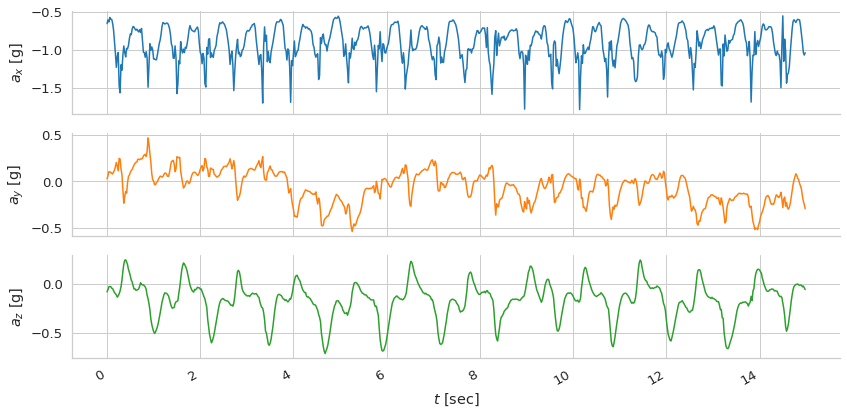

In [ ]:
ax = df.plot(subplots=True, legend=False)
ax[2].set_xlabel("$t$ [sec]")
ax[0].set_ylabel("$a_x$ [g]")
ax[1].set_ylabel("$a_y$ [g]")
ax[2].set_ylabel("$a_z$ [g]")
sns.despine()
plt.tight_layout()

Wir wählen die Beschleunigung auf der x-Achse für unser weiteres Vorgehen aus. Hier finden wir ca. 2 Tiefpunkte pro Sekunde, was einem normalen Gehtempo entspricht (zum Vergleich, siehe Video).

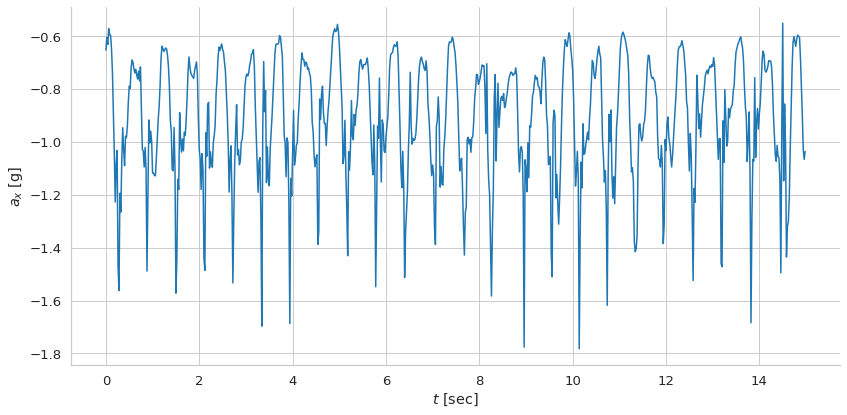

In [ ]:
plt.figure()

acc_x = df["accelX"]
ax = az.plot()
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
sns.despine()
plt.tight_layout()



## Schritt 3: Aufbereitung der Daten
1. Berechnung der Ableitung
2. Verschiebung der Ableitung
3. Finden der Tiefpunkte
4. Ergebnis anzeigen

In [ ]:
# Erzeuge Dataframe mit Accelerometersignal der x-Achse
data = pd.DataFrame(acc_x.rename("ax"))
data.head()

,ax
0.00,-0.652344
0.02,-0.604492
0.04,-0.630859
0.06,-0.570801
0.08,-0.594238


In [ ]:
# Berechne die 1. Ableitung und schreibe diese in den DataFrame
data["dax"] = data.ax.diff()
data.head()

,ax,dax
0.00,-0.652344,NaN
0.02,-0.604492,0.047852
0.04,-0.630859,-0.026367
0.06,-0.570801,0.060059
0.08,-0.594238,-0.023438


In [ ]:
# Erzeuge eine Kopie der 1. Ableitung welche um einen Zeitschritt verschoben ist.
data["dax_shift"] = data.dax.shift(-1)
data.head()

,ax,dax,dax_shift
0.00,-0.652344,NaN,0.047852
0.02,-0.604492,0.047852,-0.026367
0.04,-0.630859,-0.026367,0.060059
0.06,-0.570801,0.060059,-0.023438
0.08,-0.594238,-0.023438,-0.001221


In [ ]:
# Finde alle Tiefpunkte
data["valleys"] = (data.dax < 0) & (data.dax_shift >= 0)
data.head()

,ax,dax,dax_shift,valleys
0.00,-0.652344,NaN,0.047852,False
0.02,-0.604492,0.047852,-0.026367,False
0.04,-0.630859,-0.026367,0.060059,True
0.06,-0.570801,0.060059,-0.023438,False
0.08,-0.594238,-0.023438,-0.001221,False


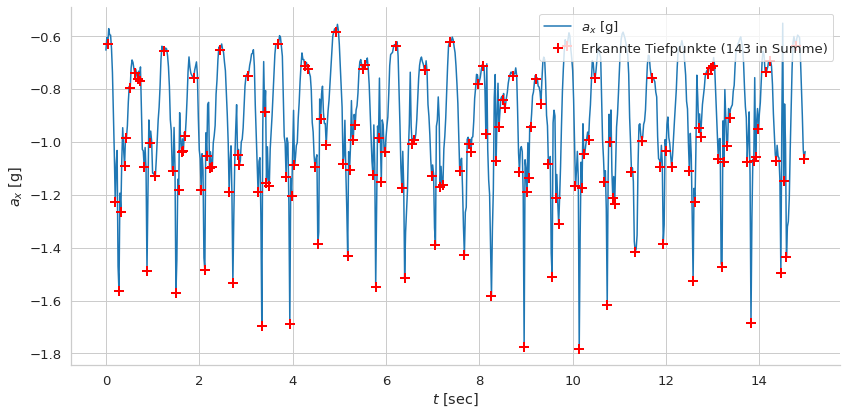

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Tiefpunkte ({data.valleys.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

## Schritt 4: Verfeinern der Regel
Hinzufügen einer 3. Bedingung um Falsch-Positive loszuwerden. Hierbei Berücksichtigung des absoluten Werts.

In [ ]:
data.ax.describe()

count    750.000000
mean      -0.910960
std        0.223554
min       -1.782227
25%       -1.049622
50%       -0.895142
75%       -0.724426
max       -0.550293
Name: ax, dtype: float64

In [ ]:
limit = data.ax.mean() - 2*data.ax.std()
data["valleys_limit"] = (data.ax < limit) & data.valleys

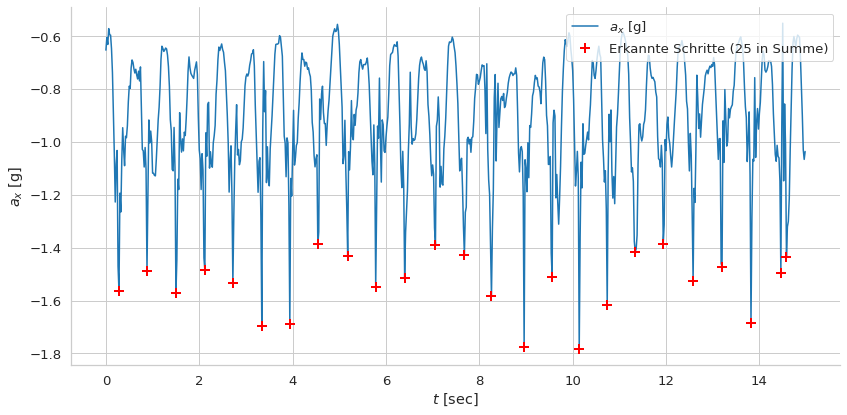

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys_limit"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Schritte ({data.valleys_limit.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()

## Schritt 5: Weitere Verfeinerung
Minimalabstand zwischen Schritten einfügen. Um Ausreisser weiter einzuschränken wollen wir einen Minimalabstand auf der x-Achse implementieren. Hierzu legen wir eine maximale Anzahl Schritte pro Sekunde fest (hier 5).

Anschließend wird der zeitliche Abstand zwischen den erkannten Tiefpunkten ermittelt und so reduziert, dass der Mindestabstand eingehalten wird.

In [ ]:
max_steps_per_sec = 5

data["valleys_time_diff"] = pd.Series(data.index[data["valleys_limit"]].values, index=data.index[data["valleys_limit"]].values).diff().fillna(np.inf)
data["valleys_timediff_limited"] = data["valleys_limit"] & (data["valleys_time_diff"] > (1/max_steps_per_sec))

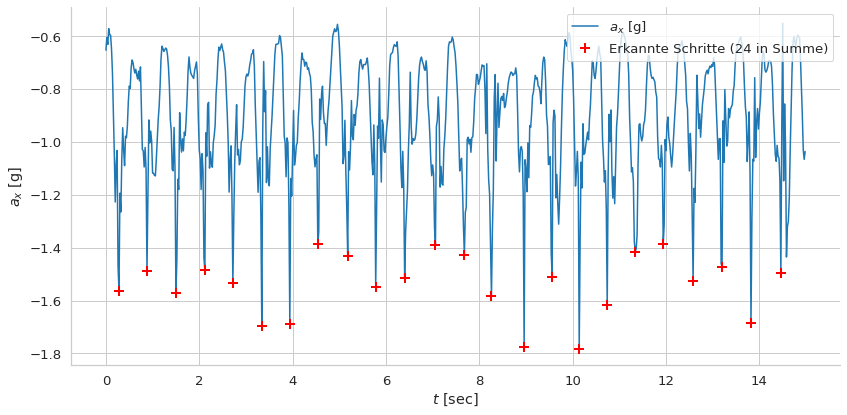

In [ ]:
plt.figure()
ax = data.ax.plot(label="$a_x$ [g]")
ax.plot(data[data["valleys_timediff_limited"]].ax, "r+", markersize=10, mew=2, label=f"Erkannte Schritte ({data.valleys_timediff_limited.sum()} in Summe)")
ax.set_xlabel("$t$ [sec]")
ax.set_ylabel("$a_x$ [g]")
ax.legend(loc=1)
sns.despine()
plt.tight_layout()